In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import pickle
import os
import admix_prs
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import admix
import admix_prs
import statsmodels.api as sm

np.random.seed(1)

In [2]:
COVAR_PATH = "DATA/covariates.txt"
df_covar = pd.read_csv(COVAR_PATH, sep="\t", index_col=0)

PHENO_PATH = "DATA/all-pheno.csv"
df_pheno = pd.read_csv(PHENO_PATH, index_col=0)

idx = list(set(df_covar.index) & set(df_pheno.index))
df_info = df_pheno.loc[idx].copy()
df_covar = df_covar.loc[idx]

for col in ["deprivation_index", "group"]:
    df_info[col] = df_covar[col]

df_info.index = df_info.index.astype(str) + "_" + df_info.index.astype(str)

# TODO: maybe it is necessary to perform quantile normalization
# df_trait_pheno["REAL"] = admix.data.quantile_normalize(df_trait_pheno["REAL"])

# load trait prediction
for trait in ["ldl_direct", "bmi", "height"]:
    df_prs = pd.read_csv(f"DATA/{trait}.tsv.gz", sep="\t", index_col=0)
    df_info[trait] = admix.data.quantile_normalize(df_info[trait])
    df_info[f"{trait}_PRED_MEAN"] = df_prs["MEAN"].reindex(df_info.index)
    df_info[f"{trait}_PRED_STD"] = df_prs["SD"].reindex(df_info.index)

In [3]:
with open("DATA/uk_train.list") as f:
    train_list = ["_".join(l.strip().split("\t")) for l in f.readlines()]
    train_list = list(set(train_list) & set(df_info.index))

In [4]:
trait = "height"

In [5]:
# add covariate effects

covar_cols = [f"PC{i}" for i in range(1, 21)] + ["AGE"] + ["SEX"]
model = sm.OLS(
    df_info[trait], sm.add_constant(df_info[covar_cols]), missing="drop"
).fit()
# df_info[f"{trait}_PRED_MEAN"] += model.predict(sm.add_constant(df_info[covar_cols]))
df_info[trait] -= model.predict(sm.add_constant(df_info[covar_cols]))

In [6]:
df_info = df_info[df_info["PC1"] > 10].dropna().copy()

# make levels
for col in ["PC1", "PC2", "AGE"]:
    df_info[f"{col}_Q"] = pd.qcut(df_info[col], q=5)

In [7]:
het_stats, het_model = admix_prs.test_het_breuschpagan(
    df=df_info.dropna(),
    y_col=trait,
    pred_col=f"{trait}_PRED_MEAN",
    test_col="AGE",
)
display(het_stats)

# we see a positive variance associated with PC1
print(het_model.summary())

Lagrange multiplier statistic    0.012530
p-value                          0.910872
f-value                          0.012529
f p-value                        0.910879
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01253
Date:                Thu, 17 Feb 2022   Prob (F-statistic):              0.911
Time:                        19:12:15   Log-Likelihood:                -16817.
No. Observations:               16870   AIC:                         3.364e+04
Df Residuals:                   16868   BIC:                         3.365e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4164      0.033     12.635      0.0

## Raw results

In [8]:
from IPython.display import display, Markdown, Latex

In [9]:
df_tmp = df_info.dropna().copy()
df_tmp[f"{trait}_PRED_MEAN"] += (
    df_tmp[f"{trait}"].mean() - df_tmp[f"{trait}_PRED_MEAN"].mean()
)

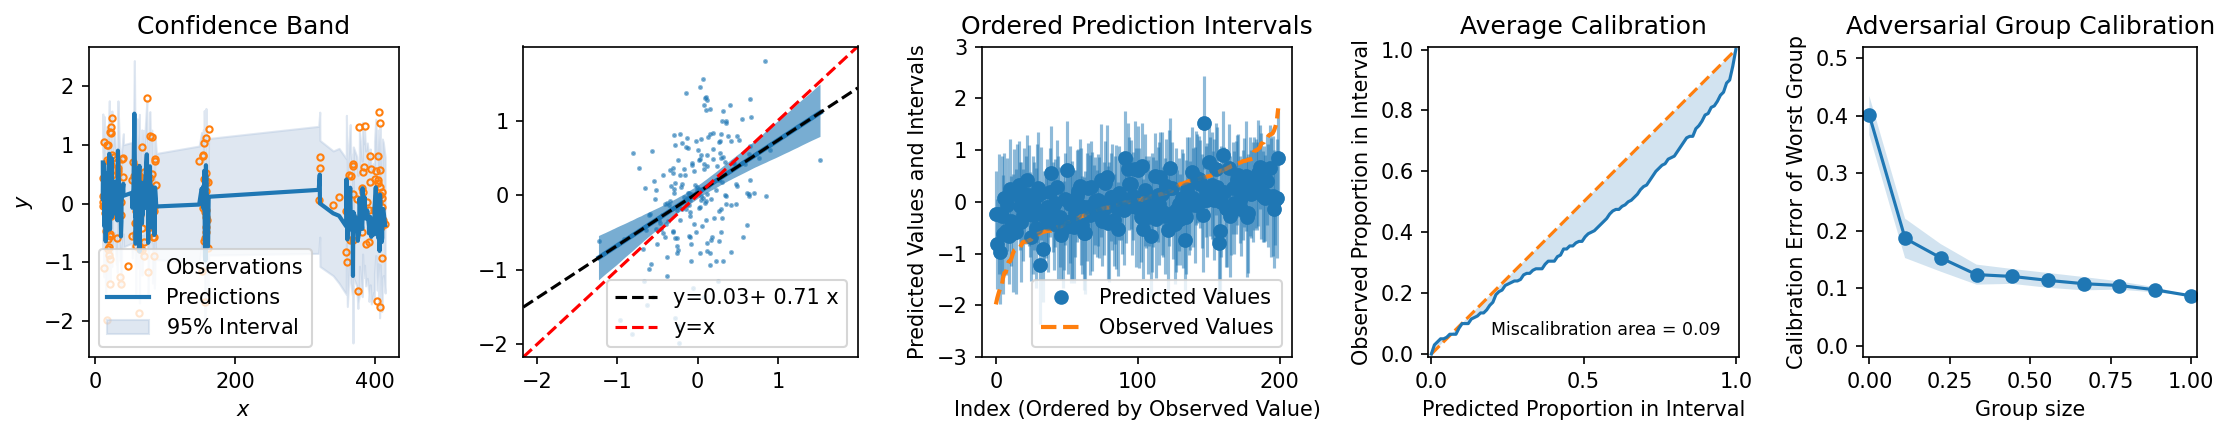

In [10]:
df_tmp = df_tmp.sample(n=200, random_state=42)
admix_prs.uct_plot(
    pred_mean=df_tmp[f"{trait}_PRED_MEAN"].values,
    pred_std=df_tmp[f"{trait}_PRED_STD"].values,
    y=df_tmp[trait].values,
    x=df_tmp["PC1"].values,
)

In [11]:
for col in ["PC1_Q", "PC2_Q", "SEX", "AGE_Q"]:
    display(Markdown(f"### {col}"))

    display(
        admix_prs.evaluate(
            df_info,
            y_col=trait,
            pred_col=f"{trait}_PRED_MEAN",
            predstd_col=f"{trait}_PRED_STD",
            group_col=col,
        )
    )

### PC1_Q

,r2,coverage,length,y_std,pred_std
PC1_Q,,,,,
"(9.999, 23.853]",0.366796,0.730883,0.700491,0.724034,0.442800
"(23.853, 64.101]",0.243281,0.738589,0.714864,0.688234,0.410750
"(64.101, 152.531]",0.172359,0.741553,0.734373,0.697570,0.393374
"(152.531, 380.798]",0.095873,0.812685,0.869406,0.680529,0.365129
"(380.798, 419.396]",0.051028,0.817131,0.943275,0.700515,0.308979


### PC2_Q

,r2,coverage,length,y_std,pred_std
PC2_Q,,,,,
"(-282.318, -104.223]",0.181279,0.768228,0.770330,0.689377,0.371734
"(-104.223, -57.256]",0.187908,0.734143,0.723758,0.681482,0.393709
"(-57.256, -8.981]",0.339755,0.739775,0.704092,0.706639,0.431026
"(-8.981, 72.211]",0.140163,0.774155,0.822152,0.723773,0.417227
"(72.211, 86.112]",0.053388,0.824541,0.942077,0.692639,0.308353


### SEX

,r2,coverage,length,y_std,pred_std
SEX,,,,,
0,0.130752,0.740153,0.799279,0.729666,0.420177
1,0.184050,0.799349,0.784917,0.663292,0.417272


### AGE_Q

,r2,coverage,length,y_std,pred_std
AGE_Q,,,,,
"(37.999, 45.0]",0.116269,0.773446,0.804991,0.687074,0.415364
"(45.0, 50.0]",0.129249,0.768908,0.806047,0.688038,0.411354
"(50.0, 56.0]",0.165915,0.785480,0.796669,0.694079,0.413437
"(56.0, 62.0]",0.198261,0.758761,0.772828,0.716674,0.427054
"(62.0, 72.0]",0.173797,0.749834,0.777993,0.710921,0.425670


# Perform calibration

In [12]:
np.random.seed(1)

calibrate_idx = np.random.choice(
    df_info.index, size=int(len(df_info) * 0.1), replace=False
).tolist()
test_idx = list(set(df_info.index) - set(calibrate_idx))

# perform calibration
df_calibrated = admix_prs.calibrate_pred(
    df_info,
    y_col=trait,
    pred_col=f"{trait}_PRED_MEAN",
    predstd_col=f"{trait}_PRED_STD",
    calibrate_idx=calibrate_idx,
    ci_method="scale",
    mean_adjust_cols=["AGE", "SEX"],
    ci_adjust_cols=["PC1"],
    ci=0.9,
)
covar_cols = [trait, "PC1", "PC2", "PC1_Q", "PC2_Q", "SEX", "AGE_Q"]
df_calibrated[covar_cols] = df_info[covar_cols].reindex(df_calibrated.index)

for col in ["PC1_Q"]:
    display(Markdown(f"### {col}"))

    display(
        admix_prs.evaluate(
            df_calibrated.loc[
                test_idx,
            ],
            y_col=trait,
            pred_col=f"{trait}_PRED_MEAN",
            predstd_col=f"{trait}_PRED_STD",
            group_col=col,
            ci=0.9,
        )
    )

2022-02-17 19:12.17 [info     ] Regress pred_col=height_PRED_MEAN against mean_adjust_cols=['AGE', 'SEX'] fitted with `calibrate_index` individuals
2022-02-17 19:12.17 [info     ] mean_model.summary():                             OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     120.8
Date:                Thu, 17 Feb 2022   Prob (F-statistic):           7.56e-71
Time:                        19:12:17   Log-Likelihood:                -1645.4
No. Observations:                1687   AIC:                             3299.
Df Residuals:                    1683   BIC:                             3321.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
        

### PC1_Q

,r2,coverage,length,y_std,pred_std
PC1_Q,,,,,
"(9.999, 23.853]",0.364556,0.910399,0.991685,0.722681,0.314701
"(23.853, 64.101]",0.229287,0.906178,0.998118,0.681876,0.292862
"(64.101, 152.531]",0.155122,0.891211,1.011972,0.695562,0.280157
"(152.531, 380.798]",0.100038,0.898917,1.085841,0.682283,0.261256
"(380.798, 419.396]",0.062167,0.878458,1.102024,0.703858,0.221715


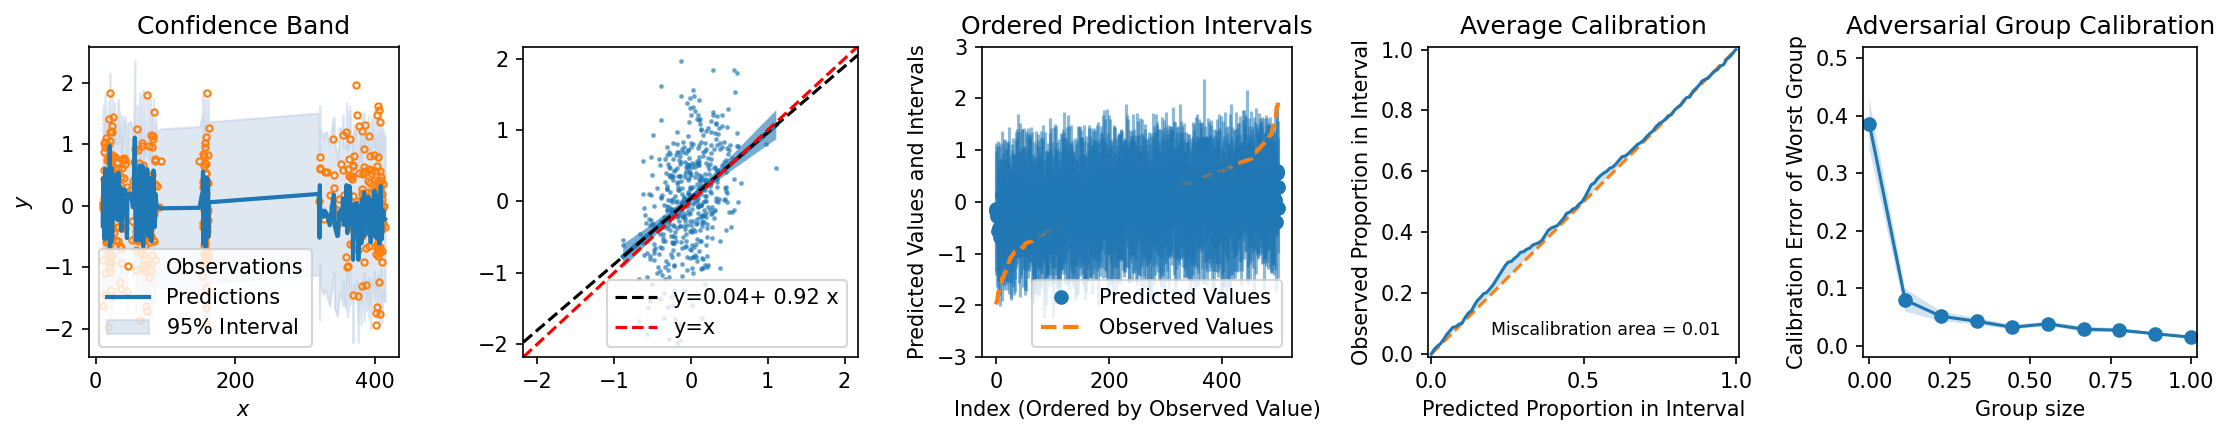

In [13]:
df_tmp = df_calibrated.sample(n=500, random_state=42)
admix_prs.uct_plot(
    pred_mean=df_tmp[f"{trait}_PRED_MEAN"].values,
    pred_std=df_tmp[f"{trait}_PRED_STD"].values,
    y=df_tmp[trait].values,
    x=df_tmp["PC1"].values,
)

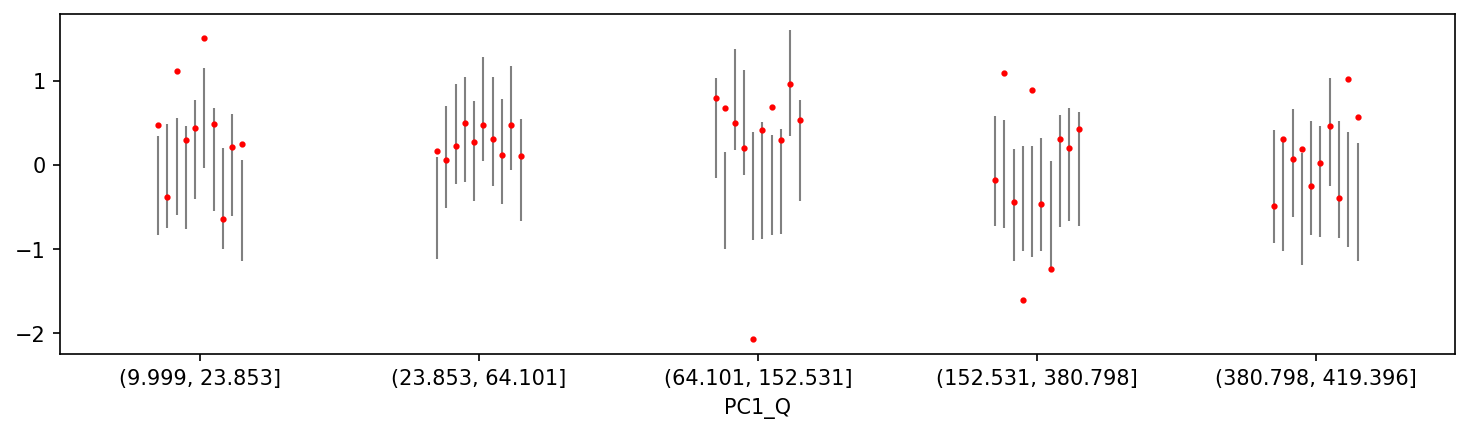

In [14]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=150)
admix_prs.plot_calibration(
    df=df_calibrated,
    y_col=trait,
    pred_col=f"{trait}_PRED_MEAN",
    predstd_col=f"{trait}_PRED_STD",
    group_col="PC1_Q",
    ax=ax,
)

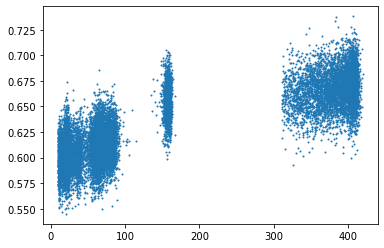

In [15]:
plt.scatter(
    df_calibrated["PC1"],
    df_calibrated[f"{trait}_PRED_STD"],
    s=1,
)